In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention

In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

In [6]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: torch.from_numpy(np.ones(x.shape[0], dtype=np.uint8))
# NOTE: the slice function _imperfectly_ targets the critical slice area.
critical_slice_fn = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.3, y=0$.
We define this slice as our `critical_region`.

In [7]:
decision_boundary_flip = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
uid_lists, Xs, Ys = generate_data(N=5000, decision_boundary_flip=decision_boundary_flip)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, 
   slice_funcs={"critical_slice": critical_slice_fn}
)[2] # take test set

Vizualizing labelset_gold from payload_test...


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


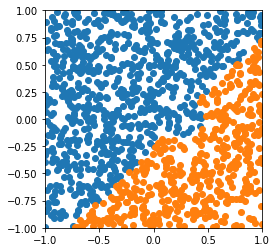

Vizualizing labelset:critical_slice from payload_test...


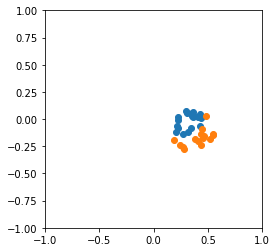

In [9]:
visualize_payload(eval_payload)

### Create tasks and payloads

In [10]:
# all models to test to test
model_configs = {
    'naive': {
        'slice_funcs': {"BASE": identity_fn},
        'model_class': MetalModel   
    },
#     'hard_param': {
#         'slice_funcs': {"critical_slice": critical_slice_fn, "BASE": identity_fn},
#         'model_class': MetalModel
#     },
    'soft_param': {
        'slice_funcs': {"critical_slice": critical_slice_fn, "BASE": identity_fn},
        'model_class': SliceModel   
    }
}

==========Initializing + Training naive==========
[BinaryClassificationTask(name=test_task, loss_multiplier=1.00, is_slice=False), BinaryClassificationTask(name=test_task:BASE, loss_multiplier=1.00, is_slice=True)]
Vizualizing labelset_gold from payload_valid...


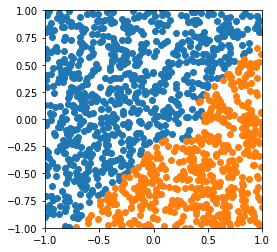

Vizualizing labelset:BASE from payload_valid...


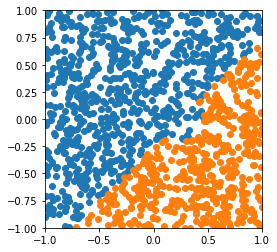

Cleaning checkpoints
{'test_task/payload_train/labelset_gold/accuracy': 0.9792, 'test_task:BASE/payload_train/labelset:BASE/accuracy': 0.9791916766706683, 'test_task/payload_valid/labelset_gold/accuracy': 0.9768, 'test_task:BASE/payload_valid/labelset:BASE/accuracy': 0.9767814251401121, 'test_task/payload_test/labelset_gold/accuracy': 0.9784, 'test_task:BASE/payload_test/labelset:BASE/accuracy': 0.978382706164932}
==========Initializing + Training soft_param==========
[BinaryClassificationTask(name=test_task, loss_multiplier=1.00, is_slice=False), BinaryClassificationTask(name=test_task:critical_slice, loss_multiplier=1.00, is_slice=True), BinaryClassificationTask(name=test_task:BASE, loss_multiplier=1.00, is_slice=True)]
Vizualizing labelset_gold from payload_valid...


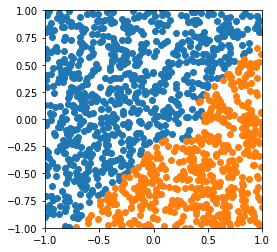

Vizualizing labelset:critical_slice from payload_valid...


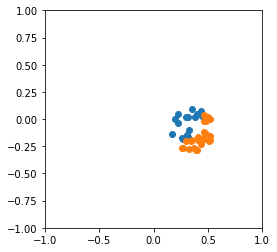

Vizualizing labelset:BASE from payload_valid...


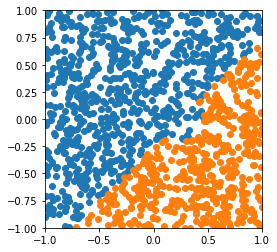

Cleaning checkpoints
{'test_task/payload_train/labelset_gold/accuracy': 0.9736, 'test_task:critical_slice/payload_train/labelset:critical_slice/accuracy': 0.7922077922077922, 'test_task:BASE/payload_train/labelset:BASE/accuracy': 0.9767907162865146, 'test_task/payload_valid/labelset_gold/accuracy': 0.9768, 'test_task:critical_slice/payload_valid/labelset:critical_slice/accuracy': 0.8780487804878049, 'test_task:BASE/payload_valid/labelset:BASE/accuracy': 0.9815852682145717, 'test_task/payload_test/labelset_gold/accuracy': 0.9768, 'test_task:critical_slice/payload_test/labelset:critical_slice/accuracy': 0.9117647058823529, 'test_task:BASE/payload_test/labelset:BASE/accuracy': 0.9807846277021617}
CPU times: user 1min 36s, sys: 1.69 s, total: 1min 37s
Wall time: 1min 42s


In [11]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    tasks = create_tasks(task_name, slice_names=list(slice_funcs.keys()))
    print(tasks)
    payloads = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, slice_funcs=slice_funcs)
    visualize_payload(payloads[1])
          
    # DEBUGGING
    model = model_class(tasks, verbose=False, seed=seed)
    trainer = MultitaskTrainer(verbose=True, lr=0.01, seed=seed)
    metrics_dict = trainer.train_model(
        model, payloads, n_epochs=30, verbose=False
    )
    print(metrics_dict)
    
    trained_models[model_name] = model

### DEBUG: Evaluate labelsets on the task heads they were trained on
to confirm whether they are learning in the first place!

In [12]:
# trained_models['hard_param'].score(payloads[2])

In [13]:
# visualize_predictions(trained_models['hard_param'], payloads[2])

In [14]:
trained_models['soft_param'].score(payloads[2])

{'test_task/payload_test/labelset_gold/accuracy': 0.9768,
 'test_task:critical_slice/payload_test/labelset:critical_slice/accuracy': 0.9117647058823529,
 'test_task:BASE/payload_test/labelset:BASE/accuracy': 0.9807846277021617}

Vizualizing test_task predictions on labelset_gold...


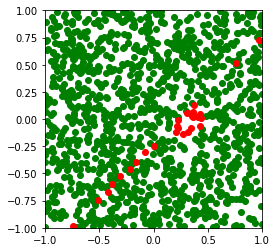

Vizualizing test_task:critical_slice predictions on labelset:critical_slice...


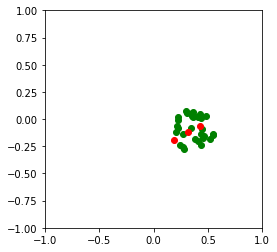

Vizualizing test_task:BASE predictions on labelset:BASE...


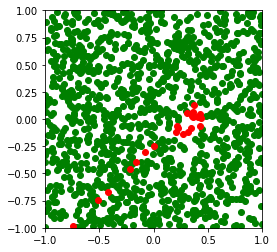

In [15]:
visualize_predictions(trained_models['soft_param'], payloads[2])

## Evaluate Model
**NOTE**: Ensure that slice labelsets are evaluated on the primary task head.

In [16]:
test_labelsets = eval_payload.labels_to_tasks.keys()
for label_name in test_labelsets:
    eval_payload.retarget_labelset(label_name, task_name)

label_set labelset_gold now points to task test_task (originally, test_task).
label_set labelset:critical_slice now points to task test_task (originally, test_task:critical_slice).


==========Evaluating naive==========
{'test_task/payload_test/labelset_gold/accuracy': 0.9784, 'test_task/payload_test/labelset:critical_slice/accuracy': 0.6764705882352942}
Vizualizing test_task predictions on labelset_gold...


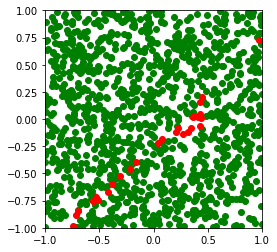

Vizualizing test_task predictions on labelset:critical_slice...


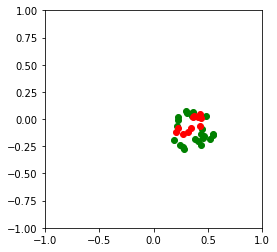

==========Evaluating soft_param==========
{'test_task/payload_test/labelset_gold/accuracy': 0.9768, 'test_task/payload_test/labelset:critical_slice/accuracy': 0.5}
Vizualizing test_task predictions on labelset_gold...


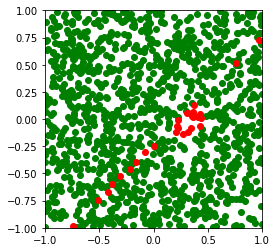

Vizualizing test_task predictions on labelset:critical_slice...


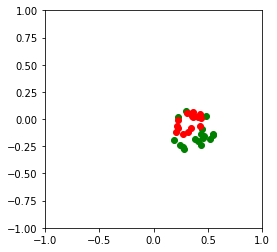

In [17]:
for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    print(trained_models[model_name].score(eval_payload))
    visualize_predictions(trained_models[model_name], eval_payload)

## Visualize Attention Weights

Vizualizing test_task:BASE attention on labelset_gold...


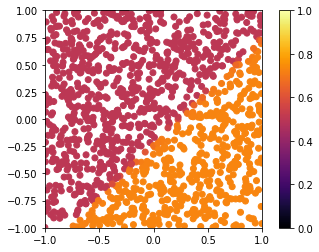

Vizualizing test_task:critical_slice attention on labelset_gold...


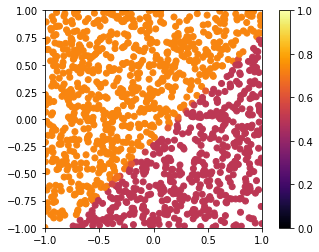

Vizualizing test_task:BASE attention on labelset:critical_slice...


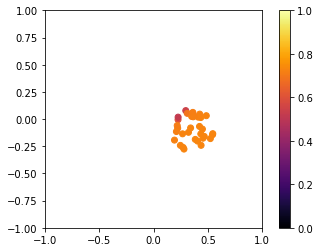

Vizualizing test_task:critical_slice attention on labelset:critical_slice...


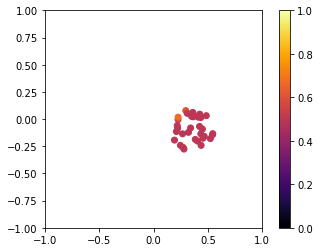

Vizualizing test_task:BASE attention on labelset:BASE...


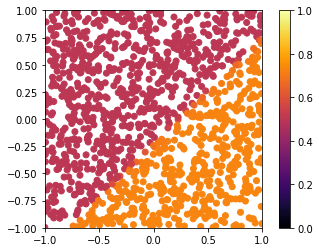

Vizualizing test_task:critical_slice attention on labelset:BASE...


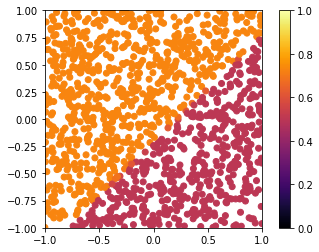

In [18]:
visualize_attention(trained_models['soft_param'], payloads[2])

### DEBUG: how often does attention choose the slice_head + we are actually in the slice?

In [19]:
from torch.nn import functional as F
payload = eval_payload

slice_task_names = sorted(
    [slice_task_name for slice_task_name in model.slice_tasks.keys()]
)

Ys, A_weights = model.attention_with_gold(payload)
X = np.array(payload.data_loader.dataset.X_dict["data"])
weights = F.softmax(torch.tensor(A_weights), dim=1).numpy()

In [20]:
np.array(A_weights)

array([[   6.597143 ,   -7.1790586],
       [ -71.214165 ,   88.13878  ],
       [ -13.575161 ,   15.480634 ],
       ...,
       [-124.931755 ,  155.85812  ],
       [   5.7771716,   -6.7025576],
       [ -48.22718  ,   58.79847  ]], dtype=float32)

In [21]:
weights

array([[9.9999893e-01, 1.0400910e-06],
       [0.0000000e+00, 1.0000000e+00],
       [2.4056316e-13, 1.0000000e+00],
       ...,
       [0.0000000e+00, 1.0000000e+00],
       [9.9999619e-01, 3.8029536e-06],
       [0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [22]:
slice_mask = critical_slice_fn(X)
slice_weights = weights[slice_mask]

In [23]:
# when do we choose the slice head? 
np.sum(slice_weights[:, 1] > slice_weights[:, 0]) / np.sum(slice_mask)

0.058823529411764705